# Speaker Diarization

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/diarization](https://github.com/huseinzol05/malaya-speech/tree/master/example/diarization).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### What is Speaker Diarization

<img src="https://miro.medium.com/max/980/1*o_gKaRSCYNxPoXyP9HV0EQ.png" width="30%">

Source image, https://miro.medium.com/max/980/1*o_gKaRSCYNxPoXyP9HV0EQ.png

In one audio sample, we want to know the timestamp for multiple speakers.

In [1]:
from malaya_speech import Pipeline
import malaya_speech
import numpy as np

### load Speaker Vector

So to know speakers similarity, we can use speaker vector, just load using `malaya_speech.speaker_vector.deep_model`. Read more about malaya-speech Speaker Vector at, https://malaya-speech.readthedocs.io/en/latest/load-speaker-vector.html

In [2]:
model = malaya_speech.speaker_vector.deep_model('speakernet')

### Load audio sample

In [3]:
y, sr = malaya_speech.load('speech/video/The-Singaporean-White-Boy.wav')
len(y), sr

(1634237, 16000)

In [4]:
# just going to take 60 seconds
y = y[:sr * 60]

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

### Load VAD

We need to use VAD module to know which parts of the audio sample are speaker activities.

In [5]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [6]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

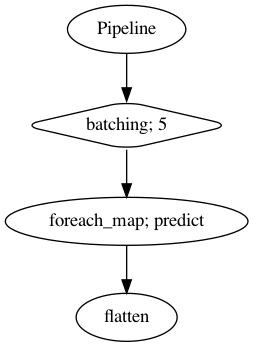

In [7]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [8]:
%%time

result = p.emit(frames)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 1min 8s, sys: 12.7 s, total: 1min 21s
Wall time: 18.7 s


dict_keys(['batching', 'predict', 'flatten'])

In [9]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

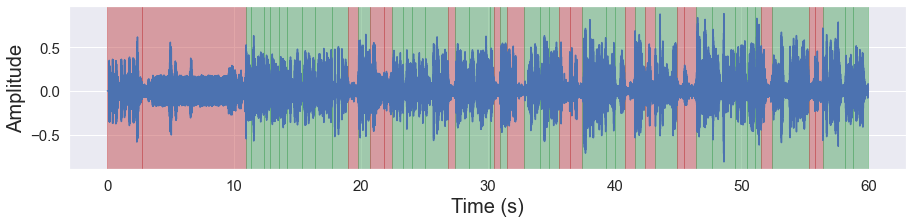

In [10]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3))

### Speaker Similarity

Simplest technique, calculate similarity,

```python
def speaker_similarity(
    vad_results,
    speaker_vector,
    similarity_threshold: float = 0.8,
    return_embedding: bool = False,
):
    """
    Speaker diarization using L2-Norm similarity.

    Parameters
    ----------
    vad_results: List[Tuple[FRAME, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    speaker_change_results: List[Tuple[FRAME, float]], optional (default=None)
        results from speaker change module, must in float result.
    similarity_threshold: float, optional (default=0.8)
        if current voice activity sample similar at least 80%, we assumed it is from the same speaker.
    speaker_change_threshold: float, optional (default=0.5)
        in one voice activity sample can be more than one speaker, split it using this threshold.

    Returns
    -------
    result : List[Tuple[FRAME, label]]
    """
```

In [11]:
result_diarization = malaya_speech.diarization.speaker_similarity(grouped_vad, model)
result_diarization[:10]

[(<malaya_speech.model.frame.FRAME at 0x14c1caed0>, 'not a speaker'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee110>, 'not a speaker'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee0d0>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee190>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee1d0>, 'speaker 1'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee250>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee290>, 'speaker 1'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee2d0>, 'speaker 1'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee350>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee310>, 'speaker 2')]

In [12]:
import matplotlib.pyplot as plt

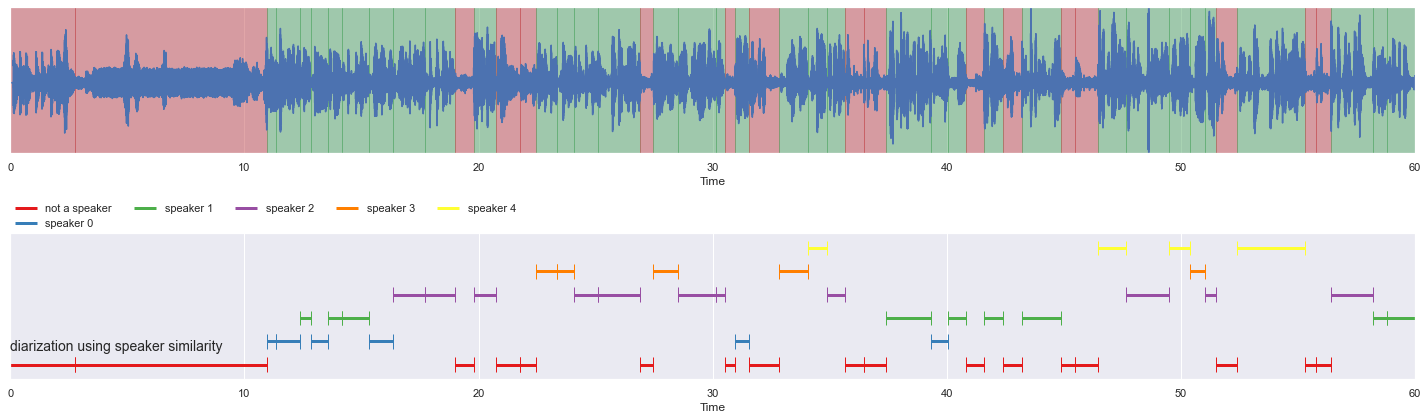

In [13]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

Problem with speaker similarity, speaker vector models are not really consistent, definition of similarity is ambigious among models, 90% similarity from model A might not be same as model B.

So, to solve this problem, we can use Affinity Propagation, a clustering technique.

### Affinity Propagation

Simply a wrapper with distance norm around sklearn,

```python
def affinity_propagation(
    vad_results,
    speaker_vector,
    metric: str = 'cosine',
    damping: float = 0.8,
    preference: float = None,
    return_embedding = False,
):
    """
    Speaker diarization using sklearn Affinity Propagation.

    Parameters
    ----------
    vad_results: List[Tuple[FRAME, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.

    Returns
    -------
    result : List[Tuple[FRAME, label]]
    """
```

In [14]:
result_diarization_ap = malaya_speech.diarization.affinity_propagation(grouped_vad, model)
result_diarization_ap[:10]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


[(<malaya_speech.model.frame.FRAME at 0x14c1caed0>, 'not a speaker'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee110>, 'not a speaker'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee0d0>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee190>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee1d0>, 'speaker 4'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee250>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee290>, 'speaker 4'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee2d0>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee350>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x14c1ee310>, 'speaker 1')]

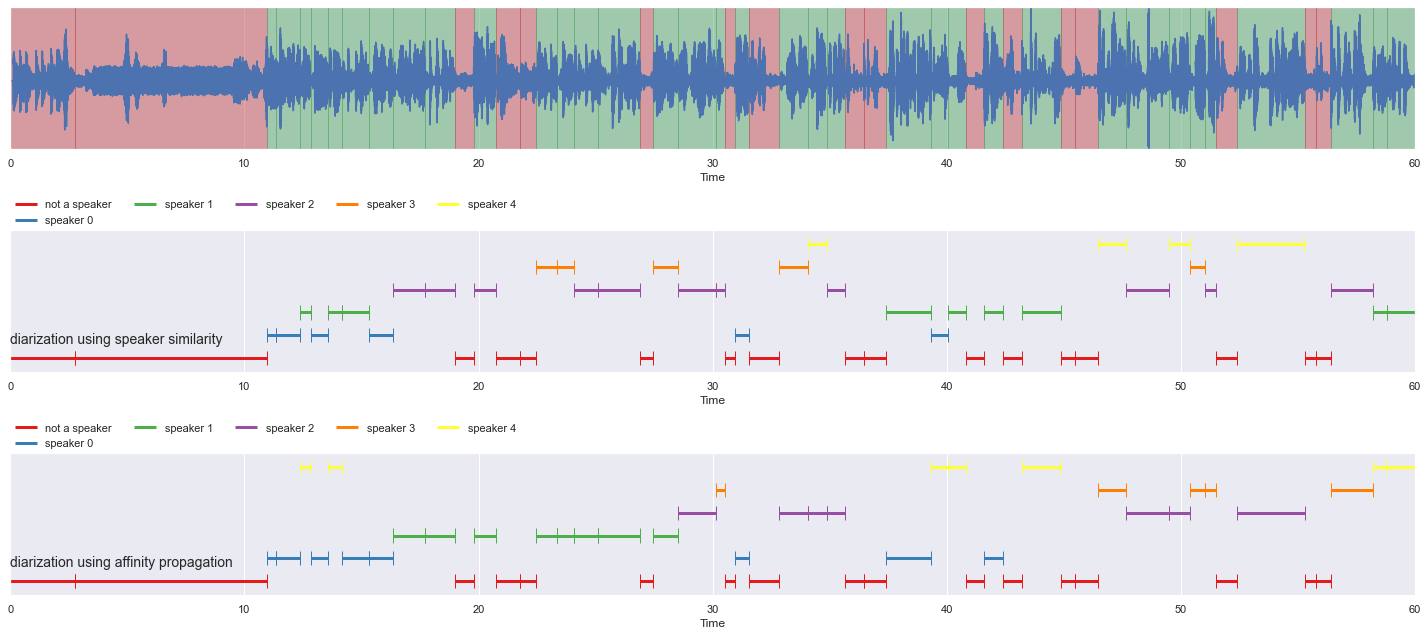

In [15]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_ap, 
                                                      'diarization using affinity propagation', ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### Use speaker change detection

In [16]:
speakernet = malaya_speech.speaker_change.deep_model('speakernet')
frames_speaker_change = list(malaya_speech.utils.generator.frames(y, 500, sr))
probs_speakernet = [(frame, speakernet.predict_proba([frame])[0, 1]) for frame in frames_speaker_change]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [19]:
nested_grouped_vad = malaya_speech.utils.group.group_frames(grouped_vad)
splitted_speakernet = malaya_speech.speaker_change.split_activities(nested_grouped_vad, probs_speakernet)

In [20]:
result_diarization_ap = malaya_speech.diarization.affinity_propagation(splitted_speakernet, model)
result_diarization_ap[:10]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


[(<malaya_speech.model.frame.FRAME at 0x158d72850>, 'not a speaker'),
 (<malaya_speech.model.frame.FRAME at 0x10b386a50>, 'speaker 2'),
 (<malaya_speech.model.frame.FRAME at 0x1575f0a10>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x1575f0fd0>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x1575f0c10>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x1575f0950>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x1575f0d10>, 'speaker 2'),
 (<malaya_speech.model.frame.FRAME at 0x158d728d0>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x158d727d0>, 'speaker 0'),
 (<malaya_speech.model.frame.FRAME at 0x1575f0a50>, 'speaker 0')]

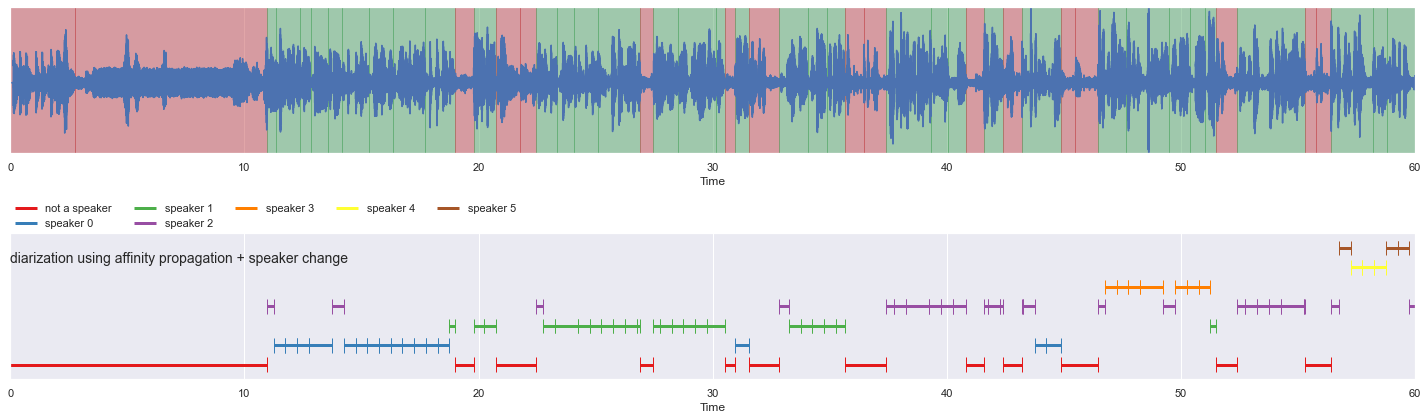

In [23]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_ap, 
                                                      'diarization using affinity propagation + speaker change', 
                                                      ax = ax[1],
                                                     x_text = 0.01, y_text = 0.8)
fig.tight_layout()
plt.show()

### Reference

1. Neural speech turn segmentation and affinity propagation for speaker diarization, Ruiqing Yin, Herve Bredin, Claude Barras, https://www.isca-speech.org/archive/Interspeech_2018/pdfs/1750.pdf